# Проект для «Викишоп»

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import nltk 
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# чтобы не было предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r"C:\Users\George\Мой диск\3 Практикум\2 Проекты\13 Машинное обучение для текстов\toxic_comments.csv")
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
# напишем функцию которая получает список слов, лемматизирует их и возвращает лемматизированное предложение
m = WordNetLemmatizer()

def lemmatize_text(text):    
    text = text.lower()
    word_list = nltk.word_tokenize(text)    
    lemm_text = ' '.join([m.lemmatize(w) for w in word_list])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

In [4]:
# Проверим работоспособность функции
print(data.loc[1, 'text'])
print()
print(lemmatize_text(data.loc[1, 'text']))

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

d aww he match this background colour i m seemingly stuck with thanks talk january utc


In [5]:
%%time

data['text'] = data['text'].apply(lemmatize_text)
data

Wall time: 1min 47s


,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i ca n t make any real suggestion on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159566,and for the second time of asking when your vi...,0
159567,you should be ashamed of yourself that is a ho...,0
159568,spitzer umm there no actual article for prosti...,0
159569,and it look like it wa actually you who put on...,0


,toxic,percent
0,143346,0.898
1,16225,0.102


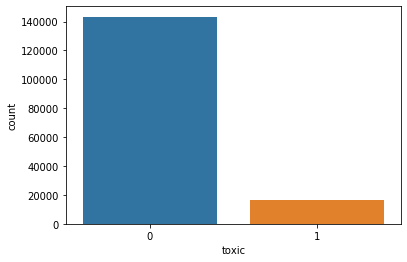

In [6]:
sns.countplot(x = 'toxic', data = data)

table = pd.DataFrame(data['toxic'].value_counts())
table['percent'] = (table['toxic']/table['toxic'].sum()).round(3)
table

In [7]:
data_toxic = data[data['toxic'] == 1]
data_not_toxic = data[data['toxic'] == 0]

In [8]:
final_data = data_toxic.sample(15000)
final_data = final_data.append(data_not_toxic.sample(15000))
final_data = final_data.reset_index(drop=True)
final_data

,text,toxic
0,i do n t believe you source a i said before sh...,1
1,i hate you i hate you i hate you,1
2,arbitrary break pedophile should have their th...,1
3,response i stand by that edit it s rude a all ...,1
4,you are a worthless piece of shit,1
...,...,...
29995,i must thank you for your support and advice a...,0
29996,sorry about falling through on the review sorr...,0
29997,if it make you feel better we can reword the a...,0
29998,hema malini article user shshshsh ha been reve...,0


In [9]:
final_data['toxic'].value_counts()

1    15000
0    15000
Name: toxic, dtype: int64

## Обучение

In [10]:
features = final_data.drop(['toxic'], axis=1)
target = final_data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [11]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(24000, 1)
(6000, 1)
(24000,)
(6000,)


In [12]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['text'].values)

features_test = count_tf_idf.transform(features_test['text'].values)

У нас есть признаки, осталось только обучить модели и выбрать из них лучшую.

### Логическая регрессия

In [13]:
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)

linear_result = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='f1').mean()
linear_result

0.8827465658233281

### Дерево решений

Воспользуемся GridSearchCV чтобы подобрать лучшие гиперпараметры

In [14]:
%%time

model = DecisionTreeClassifier()

parametrs = { 'max_depth': range(10, 101, 10) }

grid = GridSearchCV(estimator=model, cv=5, param_grid=parametrs)
grid.fit(features_train, target_train)

grid.best_params_

Wall time: 2min 23s


{'max_depth': 100}

In [15]:
model_dt = DecisionTreeClassifier(max_depth=100, random_state=12345)
model_dt.fit(features_train, target_train)

decision_tree_result = cross_val_score(model_dt, features_train, target_train, cv=5, scoring='f1').mean()
decision_tree_result

0.8068174165282862

### Случайный лес

In [16]:
%%time

model = RandomForestClassifier()

parametrs = { 'n_estimators': range(10, 101, 10),
              'max_depth': range(1, 13, 2) }
#               'min_samples_leaf': range(1, 8),
#               'min_samples_split': range(2, 11, 2) }

grid = GridSearchCV(estimator=model, cv=5, param_grid=parametrs)
grid.fit(features_train, target_train)

grid.best_params_

Wall time: 5min 35s


{'max_depth': 9, 'n_estimators': 90}

In [17]:
model_rf = RandomForestClassifier(max_depth=11, n_estimators=80, random_state=12345)
model_rf.fit(features_train, target_train)

random_forest_result = cross_val_score(model_rf, features_train, target_train, cv=5, scoring='f1').mean()
random_forest_result

0.801300247014051

In [18]:
# Построим таблицу с результатами моделей
data = {'F1_score' : [linear_result, decision_tree_result, random_forest_result]}
total_results = pd.DataFrame(data=data, index=['Логическая регрессия', 'Дерево решений', 'Случайный лес'])
total_results

,F1_score
Логическая регрессия,0.882747
Дерево решений,0.806817
Случайный лес,0.801300


Можно сделать вывод, что у логической регрессии наилучший показатель

## Выводы

In [19]:
print(f1_score(target_test, model_lr.predict(features_test)))

0.8868700719917724


В этой работе была разработана модель которая умеет классифицировать комментарии на позитивные и негативные. И лучший показатель `f1_score` получился 0.88, что намного больше поставленной в условии задачи - 0.75